# Data Input and Output

This notebook is the reference code for getting input and output, pandas can read a variety of file types using its `pd.read_` methods. Let's take a look at the most common data types:

In [1]:
import numpy as np
import pandas as pd

Let's first download some data files off of internet:

In [2]:
!curl -O https://raw.githubusercontent.com/jakevdp/data-USstates/master/state-population.csv
!curl -O https://raw.githubusercontent.com/jakevdp/data-USstates/master/state-areas.csv
!curl -O https://raw.githubusercontent.com/jakevdp/data-USstates/master/state-abbrevs.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 57935  100 57935    0     0   234k      0 --:--:-- --:--:-- --:--:--  234k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   835  100   835    0     0   8789      0 --:--:-- --:--:-- --:--:--  8789
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   872  100   872    0     0   9797      0 --:--:-- --:--:-- --:--:--  9797


## CSV

### CSV Input

Let's take a look at the three datasets, using the Pandas ``read_csv()`` function:

In [3]:
pop = pd.read_csv('state-population.csv')
areas = pd.read_csv('state-areas.csv')
abbrevs = pd.read_csv('state-abbrevs.csv')

In [4]:
pop.head()

,state/region,ages,year,population
0,AL,under18,2012,1117489.0
1,AL,total,2012,4817528.0
2,AL,under18,2010,1130966.0
3,AL,total,2010,4785570.0
4,AL,under18,2011,1125763.0


In [5]:
areas.head()

,state,area (sq. mi)
0,Alabama,52423
1,Alaska,656425
2,Arizona,114006
3,Arkansas,53182
4,California,163707


In [6]:
abbrevs.head()

,state,abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


Given this information, say we want to compute a relatively straightforward result: rank US states and territories by their 2010 population density.
We clearly have the data here to find this result, but we'll have to combine the datasets to find the result.

We'll start with a many-to-one merge that will give us the full state name within the population ``DataFrame``.
We want to merge based on the ``state/region``  column of ``pop``, and the ``abbreviation`` column of ``abbrevs``.
We'll use ``how='outer'`` to make sure no data is thrown away due to mismatched labels.

In [7]:
merged = pd.merge(pop, abbrevs, how='outer',
                  left_on='state/region', right_on='abbreviation')
merged = merged.drop('abbreviation', 1) # drop duplicate info
merged.head()

,state/region,ages,year,population,state
0,AL,under18,2012,1117489.0,Alabama
1,AL,total,2012,4817528.0,Alabama
2,AL,under18,2010,1130966.0,Alabama
3,AL,total,2010,4785570.0,Alabama
4,AL,under18,2011,1125763.0,Alabama


Let's double-check whether there were any mismatches here, which we can do by looking for rows with nulls:

In [8]:
merged.isnull().any()

state/region    False
ages            False
year            False
population       True
state            True
dtype: bool

Some of the ``population`` info is null; let's figure out which these are!

In [9]:
merged[merged['population'].isnull()].head()

,state/region,ages,year,population,state
2448,PR,under18,1990,NaN,NaN
2449,PR,total,1990,NaN,NaN
2450,PR,total,1991,NaN,NaN
2451,PR,under18,1991,NaN,NaN
2452,PR,total,1993,NaN,NaN


It appears that all the null population values are from Puerto Rico prior to the year 2000; this is likely due to this data not being available from the original source.

More importantly, we see also that some of the new ``state`` entries are also null, which means that there was no corresponding entry in the ``abbrevs`` key!
Let's figure out which regions lack this match:

In [10]:
merged.loc[merged['state'].isnull(), 'state/region'].unique()

array(['PR', 'USA'], dtype=object)

We can quickly infer the issue: our population data includes entries for Puerto Rico (PR) and the United States as a whole (USA), while these entries do not appear in the state abbreviation key.
We can fix these quickly by filling in appropriate entries:

In [11]:
merged.loc[merged['state/region'] == 'PR', 'state'] = 'Puerto Rico'
merged.loc[merged['state/region'] == 'USA', 'state'] = 'United States'
merged.isnull().any()

state/region    False
ages            False
year            False
population       True
state           False
dtype: bool

No more nulls in the ``state`` column: we're all set!

Now we can merge the result with the area data using a similar procedure.
Examining our results, we will want to join on the ``state`` column in both:

In [12]:
final = pd.merge(merged, areas, on='state', how='left')
final.head()

,state/region,ages,year,population,state,area (sq. mi)
0,AL,under18,2012,1117489.0,Alabama,52423.0
1,AL,total,2012,4817528.0,Alabama,52423.0
2,AL,under18,2010,1130966.0,Alabama,52423.0
3,AL,total,2010,4785570.0,Alabama,52423.0
4,AL,under18,2011,1125763.0,Alabama,52423.0


Again, let's check for nulls to see if there were any mismatches:

In [13]:
final.isnull().any()

state/region     False
ages             False
year             False
population        True
state            False
area (sq. mi)     True
dtype: bool

There are nulls in the ``area`` column; we can take a look to see which regions were ignored here:

In [14]:
final['state'][final['area (sq. mi)'].isnull()].unique()

array(['United States'], dtype=object)

We see that our ``areas`` ``DataFrame`` does not contain the area of the United States as a whole.
We could insert the appropriate value (using the sum of all state areas, for instance), but in this case we'll just drop the null values because the population density of the entire United States is not relevant to our current discussion:

In [15]:
final.dropna(inplace=True)
final.head()

,state/region,ages,year,population,state,area (sq. mi)
0,AL,under18,2012,1117489.0,Alabama,52423.0
1,AL,total,2012,4817528.0,Alabama,52423.0
2,AL,under18,2010,1130966.0,Alabama,52423.0
3,AL,total,2010,4785570.0,Alabama,52423.0
4,AL,under18,2011,1125763.0,Alabama,52423.0


In [16]:
data2010 = final[(final['year'] == 2010) & (final['ages'] == 'total')]
data2010.head()

,state/region,ages,year,population,state,area (sq. mi)
3,AL,total,2010,4785570.0,Alabama,52423.0
91,AK,total,2010,713868.0,Alaska,656425.0
101,AZ,total,2010,6408790.0,Arizona,114006.0
189,AR,total,2010,2922280.0,Arkansas,53182.0
197,CA,total,2010,37333601.0,California,163707.0


Now let's compute the population density and display it in order.
We'll start by re-indexing our data on the state/region, and then compute the result:

In [17]:
data2010.set_index('state/region', inplace=True)

In [18]:
density = pd.DataFrame({'density': data2010['population'] / data2010['area (sq. mi)']})
data2010_final = data2010.join(density)

In [19]:
data2010_final.sort_values('density', ascending=False, inplace=True)
data2010_final.head()

,ages,year,population,state,area (sq. mi),density
state/region,,,,,,
DC,total,2010,605125.0,District of Columbia,68.0,8898.897059
PR,total,2010,3721208.0,Puerto Rico,3515.0,1058.665149
NJ,total,2010,8802707.0,New Jersey,8722.0,1009.253268
RI,total,2010,1052669.0,Rhode Island,1545.0,681.339159
CT,total,2010,3579210.0,Connecticut,5544.0,645.600649


In [20]:
data2010_final.tail()

,ages,year,population,state,area (sq. mi),density
state/region,,,,,,
SD,total,2010,816211.0,South Dakota,77121.0,10.583512
ND,total,2010,674344.0,North Dakota,70704.0,9.537565
MT,total,2010,990527.0,Montana,147046.0,6.736171
WY,total,2010,564222.0,Wyoming,97818.0,5.768079
AK,total,2010,713868.0,Alaska,656425.0,1.087509


### CSV Output

Now let's wirte this final DataFrame to a csv file:

In [21]:
data2010_final.to_csv('data2010_final.csv',index=False)

In [22]:
!ls -lah data2010_final.csv

-rw-r--r--  1 msoltani  staff   2.9K Feb  9 03:24 data2010_final.csv


We can see our file is stored on disk.

### Plotting the result

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [24]:
# Resizing the cancvas
sns.set(rc={'figure.figsize':(11,8)})

Text(0.5, 0, 'density (population/sq. mi)')

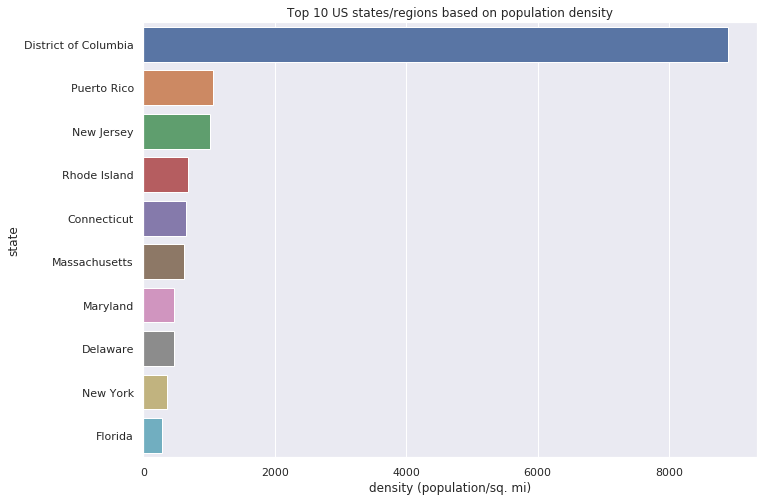

In [25]:
df = data2010_final[:10]
ax = sns.barplot(y="state", x="density", data=df)
ax.set_title('Top 10 US states/regions based on population density')
ax.set_xlabel('density (population/sq. mi)')

Text(0.5, 0, 'density (population/sq. mi)')

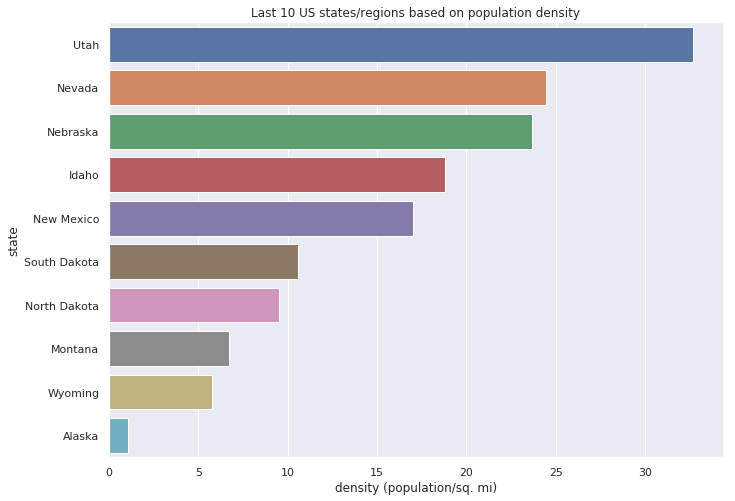

In [26]:
df = data2010_final[-10:]
ax = sns.barplot(y="state", x="density", data=df)
ax.set_title('Last 10 US states/regions based on population density')
ax.set_xlabel('density (population/sq. mi)')